# Практика 6. Введение в обработку естественного языка

In [306]:
#!pip install pymorphy2
#!pip install nltk

In [359]:
# NLP библиотеки для предобработки текста
import re
from pymorphy2 import MorphAnalyzer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Библиотеки для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

# Библиотеки для глубокого обучения
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

# Инструменты для работы с текстом и последовательностью в Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

%matplotlib inline 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [360]:
# устанавливаем генератор случайных чисел
tf.random.set_seed(0)

## 1. Предобработка данных

### Загрузка набора данных

Оригинальный источник данных: https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments

In [203]:
comments_data = pd.read_csv('data/labeled.csv')
comments_data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


### Предобработка текста (токенизация, лемматизация и удаление стоп-слов)

На этом этапе мы совершаем все шаги очистки и предварительной обработки данных, которые были описаны ранее. Мы используем лемматизацию, а не стеммизацию, потому что в процессе тестирования результатов обоих случаев лемматизация дает лучшие результаты, чем стеммизация.

In [204]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc, stopwords=stopwords_ru):
    #исключаем символы не подходящие под патерны
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    return ' '.join(tokens)

# Пример предобработки текста
simple_sentence = '#312824 Тетя Света вылези из @телефона@!!!'
lemmatize(simple_sentence, stopwords_ru)

'тётя свет вылезти телефон'

In [206]:
comments_data['processed_text'] = comments_data['comment'].apply(lemmatize)
comments_data['processed_text']

0                                         верблюд дебил бл
1        хохол это отдушина затюканый россиянин мол вон...
2                                    собака собачий смерть
3        страница обновить дебил это оскорбление доказа...
4        убедить страничный пдф скрипаль отравить росси...
                               ...                        
14407    вонючий совковый скот прибежать ныть а сторонн...
14408    а кто любить гоблин тупорылый или какой продаж...
14409    посмотреть утомлённый солнце и оказаться это х...
14410    крымотред нарушать правило раздел так к в немо...
14411    до сей пора пересматривать видео орамбо кстати...
Name: processed_text, Length: 14412, dtype: object

In [207]:
text = comments_data['processed_text']
labels = comments_data['toxic']

In [208]:
train_text, test_text, train_labels, test_labels = model_selection.train_test_split(
    text, labels, test_size=0.2, random_state=42
)

In [209]:
print(train_text.shape)
print(test_text.shape)

(11529,)
(2883,)


In [212]:
train_text.map(len).max()

6048

### Превращение текста в tfidf-матрицу

в Keras есть замечательная утилита Tokenizer которая позволяет сделать всю предобработку буквально в пару строчек кода! Больше примеров в коде можно найти тут:
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [312]:
vocab_size = 10000 # количество слов
oov_tok = '<OOV>' # OOV = Out of Vocabulary

In [313]:
# создаем токенизатор
tokenizer = Tokenizer(
    num_words=vocab_size, #размер словаря
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n•–∙—″☑️✔➥●·✅☛———————————————————————————', #фильтруем эти символы
    lower=True, #приводим к нижнему регистру
    oov_token=oov_tok #решаем проблему Out of Vocabulary
)
# обучаем токенизатор на текстах
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [314]:
# смотрим на словарь 
#word_index

In [315]:
# создаем tfidf-матрицы из текстов
train_matrix = tokenizer.texts_to_matrix(train_text, mode='tfidf')
test_matrix = tokenizer.texts_to_matrix(test_text, mode='tfidf')

In [316]:
#train_text[100]

In [317]:
#train_matrix[100]

In [318]:
train_matrix.shape

(11529, 10000)

In [319]:
train_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.74214176, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 22.31831344,  2.9497024 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.74214176, ...,  0.        ,
         0.        ,  0.        ]])

## 2. Нейронные сети прямого распространения для задачи обработки текста

### Обучаем простую нейронную сеть

In [322]:
model = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

In [323]:
# Компилируем модель
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3), #алгоритм оптимизации
    loss='binary_crossentropy', #функция потерь
    metrics=['accuracy'] #метрика
)
# Обучаем модель
history = model.fit(
    train_matrix, train_labels, #примеры и ответы к ним
    batch_size=32, #сколько примеров подаем на один шаг градиентного спуска
    epochs=10, #сколько раз будем пропускать данные через сеть
    verbose=2, #без process bar'a
    validation_data=(test_matrix, test_labels) #выборка для контроля
)

Epoch 1/10
361/361 - 2s - loss: 0.6845 - accuracy: 0.6223 - val_loss: 0.5043 - val_accuracy: 0.8040 - 2s/epoch - 7ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4608 - accuracy: 0.7817 - val_loss: 0.3562 - val_accuracy: 0.8689 - 2s/epoch - 4ms/step
Epoch 3/10
361/361 - 2s - loss: 0.3212 - accuracy: 0.8682 - val_loss: 0.3119 - val_accuracy: 0.8765 - 2s/epoch - 4ms/step
Epoch 4/10
361/361 - 2s - loss: 0.2478 - accuracy: 0.9055 - val_loss: 0.3042 - val_accuracy: 0.8772 - 2s/epoch - 4ms/step
Epoch 5/10
361/361 - 2s - loss: 0.2022 - accuracy: 0.9261 - val_loss: 0.3095 - val_accuracy: 0.8810 - 2s/epoch - 4ms/step
Epoch 6/10
361/361 - 2s - loss: 0.1656 - accuracy: 0.9409 - val_loss: 0.3264 - val_accuracy: 0.8717 - 2s/epoch - 4ms/step
Epoch 7/10
361/361 - 1s - loss: 0.1505 - accuracy: 0.9467 - val_loss: 0.3285 - val_accuracy: 0.8744 - 1s/epoch - 4ms/step
Epoch 8/10
361/361 - 2s - loss: 0.1385 - accuracy: 0.9491 - val_loss: 0.3294 - val_accuracy: 0.8734 - 2s/epoch - 4ms/step
Epoch 9/10
361/361 - 1s 

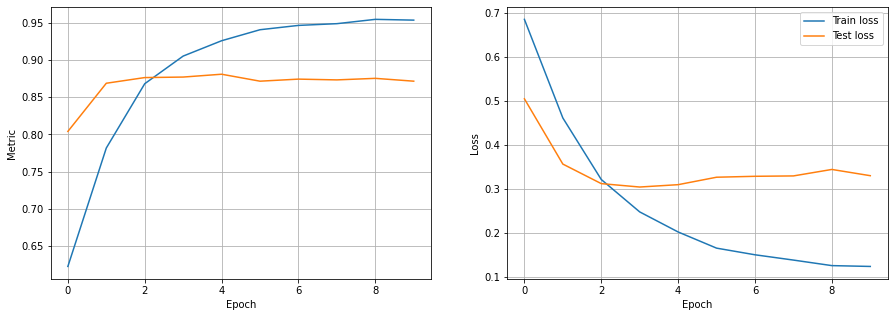

In [324]:
import matplotlib.pyplot as plt

def plot_history_learning(history, figsize=(15,5)):
    # Создаем фигуру и 2 координатные плоскости
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    # Строим два линейных графика для метрик на первой плоскости
    axes[0].plot(history.history['accuracy'], label='Train metric')
    axes[0].plot(history.history['val_accuracy'], label='Test metric')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Metric')
    axes[0].grid()
    # Строим два линейных графика для метрик на второй плоскости
    axes[1].plot(history.history['loss'], label='Train loss')
    axes[1].plot(history.history['val_loss'], label='Test loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].grid()
    
    plt.legend()
plot_history_learning(history)

## 3. Рекуррентные нейронные сети

### Превращение текста в последовательность

In [247]:
# создаем последовательности из текстов
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

In [248]:
train_text[100]

'очевидный топтать дворник ещё фёдорович весь страна заниматься это просто уровень деятельность вот попасться куколд воевак а гонор сколько дунбусый грозный дверь настежь давать говно раз когда твой сестра быть насиловать черенок веник дворник быть просто играть подземелье дракон делать вид происходить а джимми нейтрон напрячь мозг быть искать релевантный решение проблема пока сестричка венок ромашка голова раздирать дырочка ссать ты рот весь кондопог чек нацианалистъ твой маняврирование вопрос точно такой тухлый пиздабольство стрёма жирный мочь гость записиться достаточно всратый паток ах хулить мама юбка спасать наш новиоп трускаха злой фашист за пять год собраться давать рещё чучело'

In [258]:
train_text.shape

(11529,)

In [253]:
trunc_type = 'post' #метод ограничения
padding_type = 'post' #метод дополнения
embedding_dim = 64 # размер эмбединга
max_length = 50 # максимальная длина последовательности

# ограничиваем длину последовательностей 
train_padded = pad_sequences(
    train_sequences, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)

test_padded = pad_sequences(
    test_sequences, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)

In [311]:
train_padded[100]

array([2373,  637, 3400,  842,    1,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

### Обучаем простую рекуррентную нейронную сеть

In [345]:
model = models.Sequential([
    layers.Embedding(vocab_size, 64, input_length=max_length),
    layers.SimpleRNN(units=8, activation='tanh'),
    #layers.Dropout(0.1),
    layers.Dense(512, activation="relu"),
    #layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [347]:
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=10,
    batch_size=32,
    validation_data=(test_padded, test_labels)
)

Epoch 1/10
361/361 [==============================] - 4s 10ms/step - loss: 0.6328 - accuracy: 0.6629 - val_loss: 0.6251 - val_accuracy: 0.6743
Epoch 2/10
361/361 [==============================] - 4s 10ms/step - loss: 0.5798 - accuracy: 0.6923 - val_loss: 0.5508 - val_accuracy: 0.7242
Epoch 3/10
361/361 [==============================] - 4s 10ms/step - loss: 0.3644 - accuracy: 0.8480 - val_loss: 0.4682 - val_accuracy: 0.7870
Epoch 4/10
361/361 [==============================] - 4s 10ms/step - loss: 0.2164 - accuracy: 0.9205 - val_loss: 0.4812 - val_accuracy: 0.8012
Epoch 5/10
361/361 [==============================] - 4s 10ms/step - loss: 0.1448 - accuracy: 0.9521 - val_loss: 0.5207 - val_accuracy: 0.8103
Epoch 6/10
361/361 [==============================] - 4s 10ms/step - loss: 0.1033 - accuracy: 0.9676 - val_loss: 0.5706 - val_accuracy: 0.8148
Epoch 7/10
361/361 [==============================] - 4s 10ms/step - loss: 0.0791 - accuracy: 0.9764 - val_loss: 0.6168 - val_accuracy: 0.8092

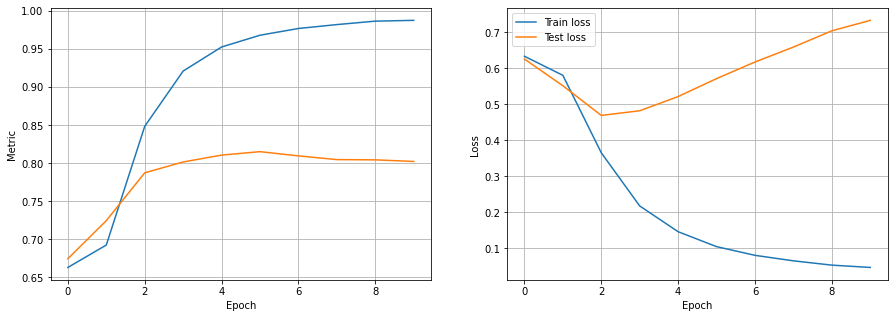

In [348]:
plot_history_learning(history)

### Обучаем рекуррентную LSTM нейронную сеть

In [354]:
model = models.Sequential([
    layers.Embedding(vocab_size, 64, input_length=max_length),
    layers.LSTM(25),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

### Callbacks

In [355]:
model_save_path = 'best_model.h5'
# callback для сохранения лучшей модели
model_checkpoint = callbacks.ModelCheckpoint(
    filepath=model_save_path, #путь до файла для сохранения
    monitor='val_loss', #на что ориентируемся при сохранении
    verbose=1, #отображать ли сохранение
    save_best_only=True, #сохраняем только самое лучшее
    save_weights_only=False, #сохраняем только веса 
)

# callback для ранней остановки модели
early_stoping = callbacks.EarlyStopping(
    monitor = "val_loss", #на что ориентируемся при остановки
    mode = "min", #потери должны быть минимальны
    patience = 10, #остановка в случае, если потери не уменьшаются n эпох
)

# callback для уменьшения learning rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', #на что ориентируемся для уменьшении
    factor=0.5, #множитель для изменения learning rate
    patience=5, #сколько эпох не должны меняться потери, чтобы уменьшить learning rate
    verbose=1, #отображать ли изменение в истории  
)

callback_list = [model_checkpoint, early_stoping, reduce_lr]


In [356]:
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=10,
    batch_size=32,
    validation_data=(test_padded, test_labels),
    callbacks=callback_list
)

Epoch 1/10
358/361 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6601
Epoch 1: val_loss improved from inf to 0.63690, saving model to best_model.h5
361/361 [==============================] - 7s 16ms/step - loss: 0.6572 - accuracy: 0.6602 - val_loss: 0.6369 - val_accuracy: 0.6743 - lr: 1.0000e-04
Epoch 2/10
360/361 [============================>.] - ETA: 0s - loss: 0.6443 - accuracy: 0.6631
Epoch 2: val_loss improved from 0.63690 to 0.63336, saving model to best_model.h5
361/361 [==============================] - 6s 17ms/step - loss: 0.6445 - accuracy: 0.6629 - val_loss: 0.6334 - val_accuracy: 0.6743 - lr: 1.0000e-04
Epoch 3/10
359/361 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.6627
Epoch 3: val_loss improved from 0.63336 to 0.62970, saving model to best_model.h5
361/361 [==============================] - 6s 15ms/step - loss: 0.6417 - accuracy: 0.6629 - val_loss: 0.6297 - val_accuracy: 0.6743 - lr: 1.0000e-04
Epoch 4/10
360/361 [===

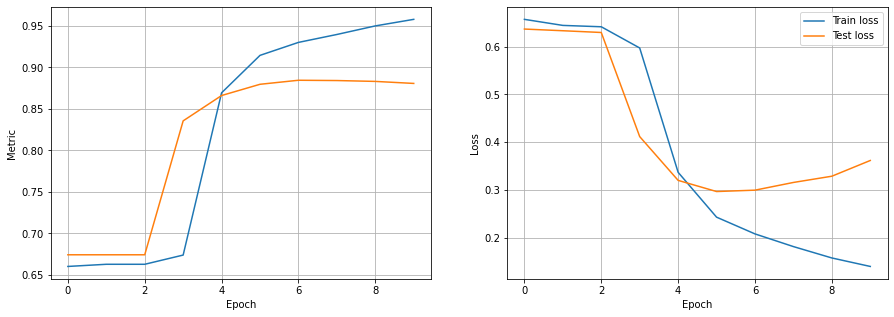

In [357]:
plot_history_learning(history)

Загружаем модель с лучшей метрикой

In [299]:
model.load_weights(model_save_path)

In [300]:
text = '''Зачем ты пишешь фигню, дегенерат? Иди прочисти себе мозги'''

In [301]:
sequence = tokenizer.texts_to_sequences([text])

In [302]:
sequence

[[485, 23, 1, 1, 553, 1, 1, 1, 1]]

In [303]:
data = pad_sequences(sequence, maxlen=max_length)

In [304]:
data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 485,  23,   1,   1, 553,   1,   1,   1,   1]])

In [305]:
result = model.predict(data)
if result > 0.5:
    print('Комментарий отрицательный')
else:
    print('Комментарий положительный')

Комментарий отрицательный


## Задания для самостоятельной работы

Меняйте гиперпараметры нейросети, чтобы повысить качество работы:
  - Длину вектора представления слов в слое Embedding.
  - Количество нейронов на рекуррентном слое (LSTM).
  - Количество рекуррентные слоев.
  - Тип оптимизатора (`adam`, `rmsprop` и др.)
  - Количество эпох обучения.
  - Размер мини-выборки.
3.Попробуйте применить вместо токенизатора Keras более совершенные:
  - [spaCy Tokenizer](https://spacy.io/usage/spacy-101#annotations-token)
  - [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
  
    Эти токенизаторы сложнее в использовании, но работают лучше.
4. Переделайте нейросеть для распознавания набора данных [Yelp reviews - Full](https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz), в котором 4 класса по количеству звезд у отзывов.